In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [9]:
%pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 3.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4032 sha256=d580d5d1c5ad1b841a115edc657d318d4475eab6d47565787af92c0d1061723f
  Stored in directory: /Users/Omar/Library/Caches/pip/wheels/a8/03/64/8557323821d25118c3a2dc1646996f7a962a8970d4b7d22473
Successfully built autograd-gamma
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23

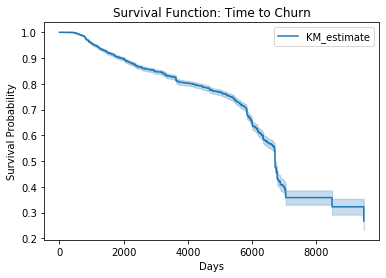

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.49 0.01      6.53

Iteration 1: norm_delta = 0.00e+00, step_size = 0.9500, log_lik = -19765.48422, newton_decrement = 0.00e+00, seconds_since_start = 0.2
Convergence success after 1 iterations.


<lifelines.CoxPHFitter: fitted with 13523 total observations, 11125 right-censored observations>
             duration col = 'Duration'
                event col = 'Churned'
      baseline estimation = breslow
   number of observations = 13523
number of events observed = 2398
   partial log-likelihood = -19765.48
         time fit was run = 2024-04-20 14:55:27 UTC

---
Empty DataFrame
Columns: [ coef,  exp(coef),  se(coef),  coef lower 95%,  coef upper 95%,  exp(coef) lower 95%,  exp(coef) upper 95%]
Index: []

Empty DataFrame
Columns: [ cmp to,  z,  p,  -log2(p)]
Index: []
---
Concordance = 0.50
Partial AIC = 39530.97
log-likelihood ratio test = 0.00 on 0 df
-log2(p) of ll-ratio test = nan

In [10]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Load data
orders_data = pd.read_csv('orders_data_competition.csv')
clients_data = pd.read_csv('clients_data_competition.csv')

### Data preprocessing as per your specification
# Adjust 'Is Dormant' values from -1 and 0 to 1 and 0 respectively
clients_data['Is Dormant'] = clients_data['Is Dormant'].replace(-1.0, 1)
clients_data['Is Dormant'] = clients_data['Is Dormant'].replace(0.0, 0)
clients_data['Is Dormant'] = clients_data['Is Dormant'].astype(int)

# Define 'Churned' column based on 'Is Closed' or 'Is Dormant'
clients_data['Churned'] = np.where((clients_data['Is Closed'] == 1) | (clients_data['Is Dormant'] == 1), 1, 0)

# Convert 'OpenDate' to datetime and calculate the duration in days
clients_data['OpenDate'] = pd.to_datetime(clients_data['OpenDate'])
clients_data['Today'] = pd.to_datetime('today')  # Assume analysis is done as of today
clients_data['Duration'] = (clients_data['Today'] - clients_data['OpenDate']).dt.days

### Survival Analysis
# Initialize the Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(durations = clients_data['Duration'], event_observed = clients_data['Churned'])

# Plot the survival function
kmf.plot_survival_function()
plt.title('Survival Function: Time to Churn')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.show()

### Compare different groups if applicable
# Example: Log-Rank Test for High Risk vs Low Risk
# First, ensure 'Risk Rate' is included and appropriately categorized if not numeric
if 'Risk Rate' in clients_data.columns:
    mask_high_risk = clients_data['Risk Rate'] == 'High'
    T = clients_data['Duration']
    E = clients_data['Churned']
    results = logrank_test(T[mask_high_risk], T[~mask_high_risk], event_observed_A=E[mask_high_risk], event_observed_B=E[~mask_high_risk])
    results.print_summary()

### Cox Proportional Hazards Model
# Preparing data for Cox model
# Include other relevant features such as 'total_orders' if data integration is required
if 'total_orders' in clients_data.columns:
    cox_data = clients_data[['Duration', 'Churned', 'total_orders']]
else:
    cox_data = clients_data[['Duration', 'Churned']]  # Modify as needed to include relevant predictors

cox_data = cox_data.dropna()  # Ensure no NaN values

# Fit Cox model
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='Duration', event_col='Churned', show_progress=True)

# Print the summary of the Cox model
cph.print_summary()
